# Export a geological model from GemPy to use in MOOSE
_implemented by [Jan Niederau](https://github.com/Japhiolite)_

This is a small example notebook guiding you through the process of exporting a geological model generated in [GemPy](https://www.gempy.org/) (Tutorial Chapter 1-1 therein) so it is usable as a Mesh in the [MOOSE](https://mooseframework.org/) framework.  



In [33]:
# These two lines are necessary only if GemPy is not installed 
import sys, os
sys.path.append("../..")

import gempy as gp

import matplotlib.pyplot as plt
%matplotlib inline

## Creating a geological model  

The procedure of generating a geological model is presented in detail in [Chapter 1-1](https://nbviewer.jupyter.org/github/cgre-aachen/gempy/blob/master/notebooks/tutorials/ch1-1_Basics.ipynb) of the GemPy tutorials, so it will only be briefly presented here

In [5]:
# Initiate a model
geo_model = gp.create_model('tutorial_moose_exp')

In [11]:
# Import data from CSV-files with setting the resolution and model extent
gp.init_data(geo_model, [0,2000., 0,2000., 0,2000.], [50, 50, 80],
            path_o = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_orientations.csv",
            path_i = os.pardir+"/data/input_data/tut_chapter1/simple_fault_model_points.csv",
            default_values = True);

Active grids: ['regular']


In [12]:
# present the units and series
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,Shale,Default series,1,False,#015482,1
1,Sandstone_1,Default series,2,False,#9f0052,2
2,Siltstone,Default series,3,False,#ffbe00,3
3,Sandstone_2,Default series,4,False,#728f02,4
4,Main_Fault,Default series,5,False,#443988,5
5,basement,Basement,1,True,#ff3f20,6


In [16]:
# combine units in series and make two series, as the fault needs its own
gp.map_series_to_surfaces(geo_model,
                         {"Fault_Series" : 'Main_Fault',
                          "Strat_Series" : ('Sandstone_2', 'Siltstone', 'Shale', 'Sandstone_1', 'basement')},
                         remove_unused_series=True);

# set the fault series to be fault object
geo_model.set_is_fault(['Fault_Series'], change_color=False)

,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [17]:
# check whether series were assigned correctly
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#443988,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Strat_Series,5,True,#ff3f20,6


## Model generation
After loading in the data, we set it up for interpolation and compute the model.

In [18]:
# set up interpolator
gp.set_interpolation_data(geo_model,
                          compile_theano=True, 
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


In [20]:
# compute the model
gp.compute_model(geo_model, compute_mesh=False);

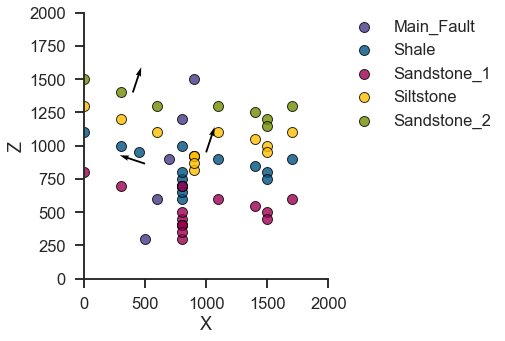

In [32]:
# have a look at the data and computed model
gp.plot.plot_data(geo_model, direction='y')

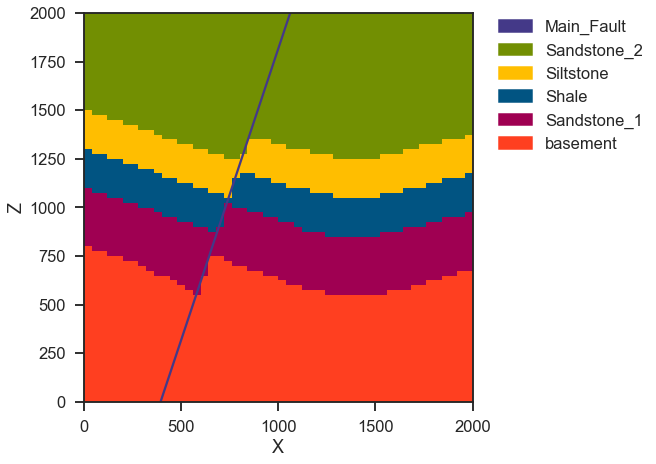

In [30]:
gp.plot.plot_section(geo_model, cell_number=24, direction='y',
                     show_data=False, show_legend=True)

## Exporting the Model to MOOSE  
The voxel-model above already is the same as a model discretized in a hexahedral grid, so my immediately be used as input in a simulation tool, e.g. [MOOSE](https://mooseframework.org/). For this, we need to access to the unit IDs assigned to each voxel in GemPy. The array containing these IDs is called `lith_block`. 

In [34]:
ids = geo_model.solutions.lith_block
print(ids)

[6. 6. 6. ... 2. 2. 2.]


This array has the shape of `(x,)` and would be immediately useful, if GemPy and the chosen simulation code would _populate_ a grid in the same way. Of course, however, that is not the case. This is why we have to restructure the `lith_block` array, so it can be read correctly by MOOSE.

In [39]:
# model resolution
nx, ny, nz = geo_model.grid.regular_grid.resolution

# model extent
xmin, xmax, ymin, ymax, zmin, zmax = geo_model.grid.regular_grid.extent

These two parameters are important to, a) restructure `lith_block`, and b) write the input file for MOOSE correctly. 
For a), we need to reshape `lith_block` again to its three dimensions and _re-flatten_ it in a _MOOSE-conform_ way.

In [40]:
# reshape to 3D array
units = ids.reshape((nx, ny, nz))
# flatten MOOSE conform
units = units.flatten('F')

The importance of `nx, ny, nz` is apparent from the cell above. But what about `xmin`, ..., `zmax`?  
A MOOSE input-file for mesh generation has the following syntax:  

```python
[MeshGenerators]
  [./gmg]
    type = GeneratedMeshGenerator
    dim = 3
    nx = 50
    ny = 50
    nz = 80
    xmin = 0.0
    xmax = 2000.0
    yim = 0.0
    ymax = 2000.0
    zmin = 0.0
    zmax = 2000.0
    block_id = '1 2 3 4 5 6'
    block_name = 'Main_Fault Sandstone_2 Siltstone Shale Sandstone_1 basement'
  [../]

  [./subdomains]
    type = ElementSubdomainIDGenerator
    input = gmg
    subdomain_ids = ' ' # here you paste the transformed lith_block vector
  [../]
[]

[Mesh]
  type = MeshGeneratorMesh
[]
```

So these parameters are required inputs in the `[MeshGenerators]` object in the MOOSE input file. `GemPy` has a method to directly create such an input file, stored in `gempy.utils.export.py`.  

The following cell shows how to call the method:

In [42]:
import gempy.utils.export as export
export.export_moose_input(geo_model, path='')

Successfully exported geological model as moose input to ./


This method automatically stores a file `geo_model_units_moose_input.i` at the specified path. Either this input file could be extended with parameters to directly run a simulation, or it is used just for creating a mesh. In the latter case, the next step would be, to run the compiled MOOSE executable witch the optional flag `--mesh-only`.  

E.g. with using the [PorousFlow module](https://mooseframework.inl.gov/modules/porous_flow/):

```bash
$path_to_moose/moose/modules/porous_flow/porous_flow-opt -i pct_voxel_mesh.i --mesh-only
```

How to compile MOOSE is described in their [documentation](https://mooseframework.inl.gov/getting_started/index.html). 

The now generated mesh with the name `geo_model_units_moose_input_in.e` can be used as input for another MOOSE input file, which contains the main simulation parameters. To call the file with the grid, the following part has to be added in the MOOSE simulation input file:  

```python
[Mesh]
  file = geo_model_units_moose_input_in.e
[]
```

<hr>

The final output of the simulation may also be such an `.e`, which can, for instance, be opened with [paraview](https://www.paraview.org/). A simulated temperature field (purely conductive) of the created model would look like this:  

![gempy_temperature](https://raw.githubusercontent.com/Japhiolite/a-Moose-and-you/master/imgs/GemPy_model_combined.png)